# Combining Physics-informed Neural Networks and Bayesian inference for nonlinear filtering
## Author
- **Name**: Azimov Sherkhon Azizkhon Ugli
- **Email**: sherkhonazim@gmail.com
- **GitHub**: @AzimovSherkhon

Method: **PINNs Bayes** \
PDE: Forward Kolmogorov Equation

Parameters:\
κ=0.5 (Low Noise Strength),\
t_obs = 2 (Observation Frequency). 

Neural Network Structure: \
The network consists of two hidden layers, each with 50 neurons and Tanh activations. \
The final output layer uses Softplus. 

Training Setup: \
The Adam optimizer's learning_rate_adam = 0.01 and adam_iterations = 5,000. \
The L-BFGS optimizer's learning_rate_lbfgs = 0.05 and lbfgs_iterations = 1,000. 

Initialization: \
Xavier uniform initialization is used for weights. \
Biases are initialized to zero. 

In [1]:
import torch
import numpy as np
from torch import nn, optim
import torch.nn.init as init
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.current_device()} - {torch.cuda.get_device_name(0)}")

Device in use: cuda
CUDA available: True
CUDA device: 0 - NVIDIA GeForce RTX 3060


In [2]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
domain_length, num_points, num_time_steps, time_start, time_end = 2.0, 401, 201, 0.0, 2.0
learning_rate_adam, learning_rate_lbfgs = 0.01, 0.05  
adam_iterations, lbfgs_iterations = 5000, 1000  

x_coords = torch.linspace(-domain_length, domain_length, num_points, requires_grad=True, device=device)
t_coords = torch.linspace(time_start, time_end, num_time_steps, requires_grad=True, device=device)
x_grid, t_grid = torch.meshgrid(x_coords, t_coords, indexing="ij")
x_flat, t_flat = x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)
Ne = 50

# Define the MLP model
def create_mlp():
    model = nn.Sequential(
        nn.Linear(2, Ne),
        nn.Tanh(),
        nn.Linear(Ne, Ne),
        nn.Tanh(),
        nn.Linear(Ne, 1),
        nn.Softplus()  
    )
    return model.to(device)


model = create_mlp()
# Define optimizers
optimizer_adam = optim.Adam(model.parameters(), lr=learning_rate_adam)
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=learning_rate_lbfgs)

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            init.zeros_(layer.bias)
model.apply(initialize_weights)

def compute_derivative(output, input_var):
    return torch.autograd.grad(output, input_var, grad_outputs=torch.ones_like(output, device=device), create_graph=True)[0]

def compute_loss(x, t):
    inputs = torch.cat((x, t), 1)
    initial_inputs = torch.cat((x, 0 * t), 1)
    left_boundary = torch.cat((-domain_length + 0 * x, t), 1)
    right_boundary = torch.cat((domain_length + 0 * x, t), 1)

    solution = model(inputs)
    solution_t = compute_derivative(solution, t)
    solution_x = compute_derivative(solution, x)
    solution_xx = compute_derivative(solution_x, x)

    pde_residual = solution_t - (12 * x**2 - 4) * solution - 4 * x * (x**2 - 1) * solution_x - 0.125 * solution_xx
    initial_pdf = (1 / torch.tensor(1920.6414, device=device)) * torch.exp(-(2 * x**2) * (x**2 - 2) / torch.tensor(0.5, device=device)**2)
    initial_residual = model(initial_inputs) - initial_pdf

    left_bc_solution = model(left_boundary)
    right_bc_solution = model(right_boundary)
    left_deriv = compute_derivative(left_bc_solution, left_boundary)
    right_deriv = compute_derivative(right_bc_solution, right_boundary)

    return (pde_residual**2).mean() + 10*(initial_residual**2).mean() + 10*(left_deriv**2).mean() + 10*(right_deriv**2).mean()

# Closure for L-BFGS
def closure():
    optimizer_lbfgs.zero_grad()
    loss = compute_loss(x_flat, t_flat)
    loss.backward()
    return loss

start_time = time.time()
loss_history, min_loss, best_model_weights = [], float('inf'), None
patience, loss_threshold, stagnant_count = 20, 1e-8, 0

# Phase 1: Train with Adam
print("Starting Adam optimization...")
for iteration in range(adam_iterations):
    optimizer_adam.zero_grad()
    loss = compute_loss(x_flat, t_flat)
    loss.backward()
    optimizer_adam.step()
    
    current_loss = loss.item()
    loss_history.append(current_loss)

    if current_loss < min_loss:
        min_loss = current_loss
        best_model_weights = model.state_dict()

    if len(loss_history) > 1 and abs(loss_history[-1] - loss_history[-2]) < loss_threshold:
        stagnant_count += 1
        if stagnant_count >= patience:
            print(f"Adam: Early stopping at iteration {iteration} with loss: {current_loss:.2e}")
            break
    else:
        stagnant_count = 0

    if iteration % 1000 == 0:
        print(f"Adam Epoch {iteration:4d}: Current loss: {current_loss:.2e}")

# Phase 2: Switch to L-BFGS
print("\nSwitching to L-BFGS optimization...")
for iteration in range(lbfgs_iterations):
    current_loss = optimizer_lbfgs.step(closure).item()
    loss_history.append(current_loss)

    if current_loss < min_loss:
        min_loss = current_loss
        best_model_weights = model.state_dict()

    if len(loss_history) > 1 and abs(loss_history[-1] - loss_history[-2]) < loss_threshold:
        stagnant_count += 1
        if stagnant_count >= patience:
            print(f"L-BFGS: Early stopping at iteration {iteration} with loss: {current_loss:.2e}")
            break
    else:
        stagnant_count = 0

    if iteration % 100 == 0:
        print(f"L-BFGS Epoch {iteration:4d}: Current loss: {current_loss:.2e}")

# Load best model weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print(f"\nLoaded best model with loss: {min_loss:.2e}")

training_duration = time.time() - start_time
print(f"Training completed in {training_duration:.2f} seconds.")
loss_history = np.array(loss_history)

Starting Adam optimization...
Adam Epoch    0: Current loss: 1.96e+02
Adam Epoch 1000: Current loss: 2.21e+00
Adam Epoch 2000: Current loss: 1.48e-01
Adam Epoch 3000: Current loss: 4.02e-02
Adam Epoch 4000: Current loss: 3.55e-02

Switching to L-BFGS optimization...
L-BFGS Epoch    0: Current loss: 4.18e-02
L-BFGS Epoch  100: Current loss: 3.65e-04
L-BFGS Epoch  200: Current loss: 3.21e-05
L-BFGS: Early stopping at iteration 294 with loss: 1.29e-05

Loaded best model with loss: 1.29e-05
Training completed in 460.83 seconds.


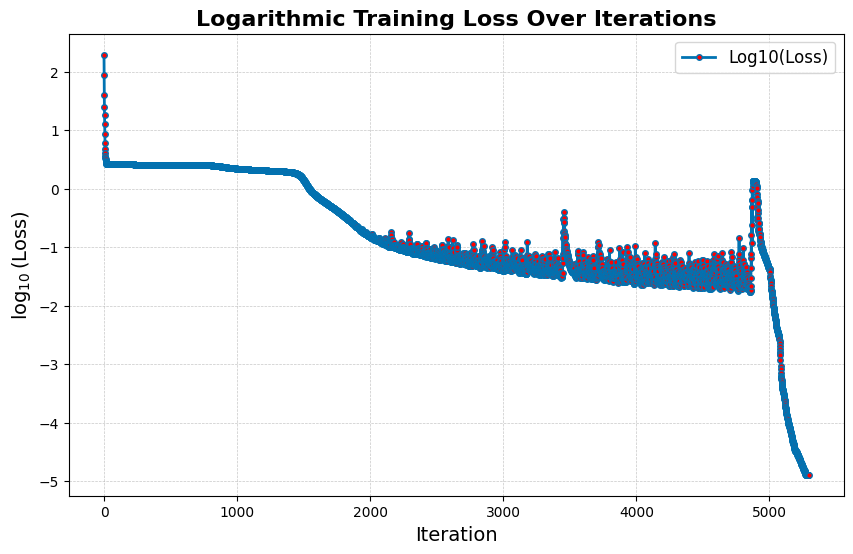

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(loss_history)), np.log10(loss_history),
    label="Log10(Loss)", color="#0173b2", linewidth=2,
    linestyle="-", marker="o", markersize=4, markerfacecolor="red"
)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel(r"$\log_{10}(\text{Loss})$", fontsize=14)
plt.title("Logarithmic Training Loss Over Iterations", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc="upper right")
plt.savefig("Log10_Loss_Plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
x_coords_torch = torch.linspace(-domain_length, domain_length, num_points, device=device)
t_coords_torch = torch.linspace(time_start, time_end, num_time_steps, device=device)
x_grid, t_grid = torch.meshgrid(x_coords_torch, t_coords_torch, indexing="ij")
inputs = torch.cat((x_grid.reshape(-1, 1), t_grid.reshape(-1, 1)), 1)

prediction = model(inputs).reshape(num_points, num_time_steps).cpu().detach().numpy()
x_coords_np = np.linspace(-domain_length, domain_length, num_points)
spatial_step = x_coords_np[1] - x_coords_np[0]

for i in range(num_time_steps):
    prediction[:, i] /= np.sum(prediction[:, i]) * spatial_step

last_column = prediction[:, -1]
print(f"Integral of last timestep: {np.sum(last_column) * spatial_step:.6f}")

Integral of last timestep: 1.000000


[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48.]


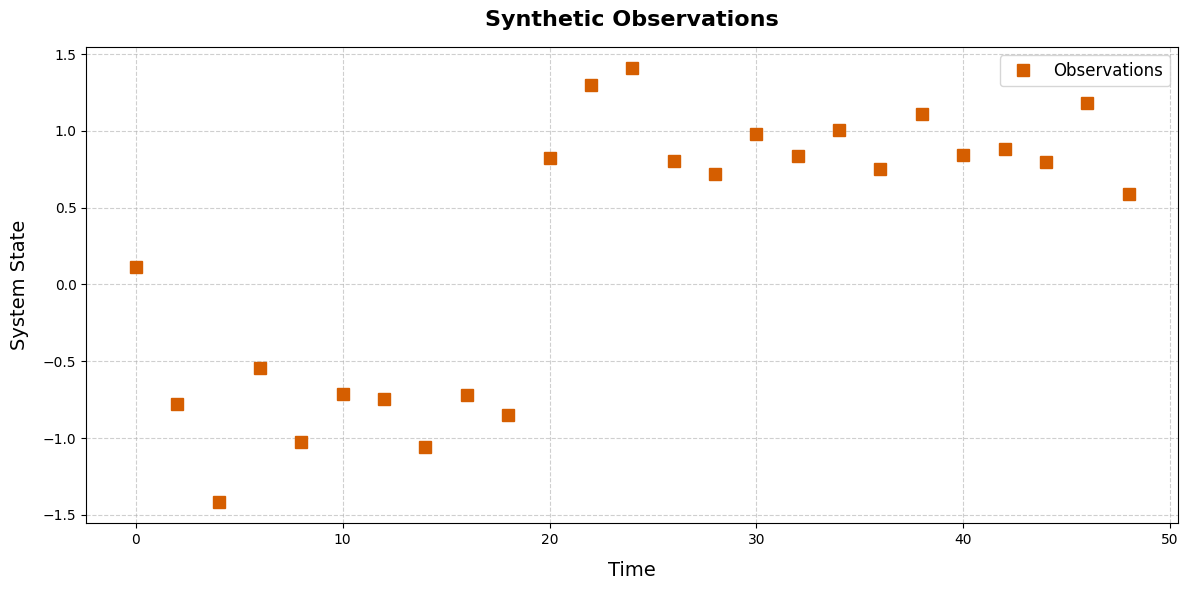

In [5]:
observations = np.load("Obs_doublewell2_k_0.5.npy")
observation_times = np.load("Obs_time_doublewell2_k_0.5.npy")
print(observation_times)

plt.figure(figsize=(12, 6))
plt.plot(observation_times, observations, label="Observations", marker="s", color="#D55E00", linestyle="None", markersize=8)

plt.xlabel("Time", fontsize=14, labelpad=10)
plt.ylabel("System State", fontsize=14, labelpad=10)
plt.title("Synthetic Observations", fontsize=16, fontweight="bold", pad=15)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [6]:
def compute_posterior(obs, obs_noise_std, x_coords, prior_pdf):
    epsilon = 1e-5 * np.max(prior_pdf)
    prior_pdf = np.where(prior_pdf < epsilon, epsilon, prior_pdf)
    spatial_step = x_coords[1] - x_coords[0]
    prior_pdf = prior_pdf / (np.sum(prior_pdf) * spatial_step)
    log_prior = np.log(prior_pdf)
    log_likelihood = -((obs - x_coords) ** 2) / (2 * obs_noise_std ** 2)
    likelihood = np.exp(log_likelihood)
    normalized_likelihood = likelihood / (np.sum(likelihood) * spatial_step)
    log_posterior = log_likelihood + log_prior
    unnormalized_posterior = np.exp(log_posterior)
    posterior = unnormalized_posterior / (np.sum(unnormalized_posterior) * spatial_step)
    mean_posterior = np.sum(x_coords * posterior * spatial_step)
    variance_posterior = np.sum((x_coords ** 2) * posterior * spatial_step) - mean_posterior ** 2
    std_posterior = np.sqrt(variance_posterior)

    plt.figure(figsize=(12, 6))
    plt.plot(x_coords, prior_pdf, label="Prior", color="#0072B2", linewidth=2)
    plt.plot(x_coords, normalized_likelihood, label="Likelihood", color="#009E73", linewidth=2)
    plt.plot(x_coords, posterior, label="Posterior", color="#D55E00", linewidth=2)
    plt.xlabel("x", fontsize=14, labelpad=10)
    plt.ylabel("Probability Density", fontsize=14, labelpad=10)
    plt.title("Prior, Likelihood, and Posterior", fontsize=16, fontweight="bold", pad=15)
    plt.legend(fontsize=12, loc="upper right", frameon=True)
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return posterior, mean_posterior, std_posterior

In [7]:
def compute_loss_new(x, t, posterior):
    inputs = torch.cat((x, t), 1)
    initial_inputs = torch.cat((x, 0 * t), 1)
    left_boundary = torch.cat((-domain_length + 0 * x, t), 1)
    right_boundary = torch.cat((domain_length + 0 * x, t), 1)

    solution = model(inputs)
    solution_t = compute_derivative(solution, t)
    solution_x = compute_derivative(solution, x)
    solution_xx = compute_derivative(solution_x, x)

    pde_residual = solution_t - (12 * x**2 - 4) * solution - 4 * x * (x**2 - 1) * solution_x - 0.125 * solution_xx
    initial_data = torch.from_numpy(posterior).to(device).to(torch.float32)
    initial_residual = model(initial_inputs) - initial_data

    left_solution = model(left_boundary)
    right_solution = model(right_boundary)
    left_deriv = compute_derivative(left_solution, left_boundary)
    right_deriv = compute_derivative(right_solution, right_boundary)

    return (pde_residual**2).mean() + 10 * (initial_residual**2).mean() + 10 * (left_deriv**2).mean() + 10 * (right_deriv**2).mean()

def closure_new():
    loss = compute_loss_new(x_flat, t_flat, posterior_expanded)
    optimizer_lbfgs.zero_grad()
    loss.backward()
    return loss

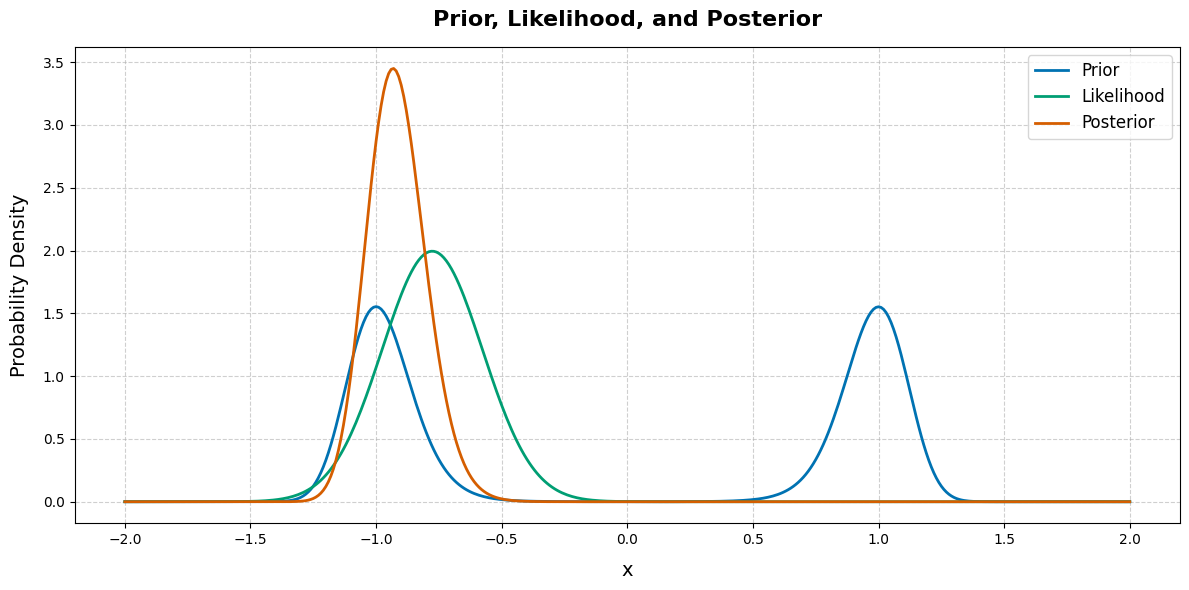

Step 1, Starting Adam optimization...
Step 1, Adam Epoch    0: Current loss: 1.99e+02
Step 1, Adam Epoch 1000: Current loss: 4.28e-01
Step 1, Adam Epoch 2000: Current loss: 2.87e-01
Step 1, Adam Epoch 3000: Current loss: 9.35e-02
Step 1, Adam Epoch 4000: Current loss: 7.95e-02
Step 1, Switching to L-BFGS optimization...
Step 1, L-BFGS Epoch    0: Current loss: 1.10e-01
Step 1, L-BFGS Epoch  100: Current loss: 2.88e-04
Step 1, L-BFGS Epoch  200: Current loss: 1.37e-04
Step 1, L-BFGS Epoch  300: Current loss: 6.86e-05
Step 1, L-BFGS Epoch  400: Current loss: 4.77e-05
Step 1, L-BFGS Epoch  500: Current loss: 3.51e-05
Step 1, L-BFGS Epoch  600: Current loss: 2.53e-05
Step 1, L-BFGS Epoch  700: Current loss: 2.20e-05
Step 1, L-BFGS: Early stopping at iteration 727 with loss: 2.17e-05
Step 1, Loaded best model with loss: 2.17e-05


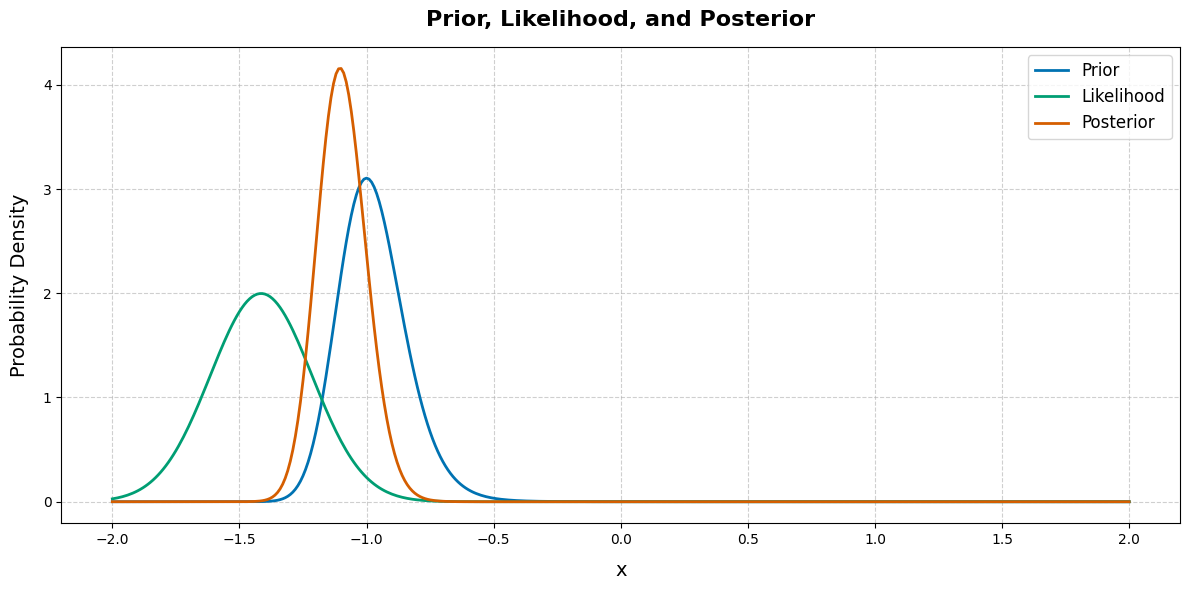

Step 2, Starting Adam optimization...
Step 2, Adam Epoch    0: Current loss: 2.01e+02
Step 2, Adam Epoch 1000: Current loss: 9.59e-01
Step 2, Adam Epoch 2000: Current loss: 4.35e-01
Step 2, Adam Epoch 3000: Current loss: 1.53e-01
Step 2, Adam Epoch 4000: Current loss: 1.65e-01
Step 2, Switching to L-BFGS optimization...
Step 2, L-BFGS Epoch    0: Current loss: 6.16e-02
Step 2, L-BFGS Epoch  100: Current loss: 7.47e-04
Step 2, L-BFGS Epoch  200: Current loss: 4.40e-04
Step 2, L-BFGS Epoch  300: Current loss: 2.43e-04
Step 2, L-BFGS Epoch  400: Current loss: 1.20e-04
Step 2, L-BFGS Epoch  500: Current loss: 7.88e-05
Step 2, L-BFGS Epoch  600: Current loss: 5.67e-05
Step 2, L-BFGS Epoch  700: Current loss: 4.09e-05
Step 2, L-BFGS: Early stopping at iteration 790 with loss: 3.69e-05
Step 2, Loaded best model with loss: 3.69e-05


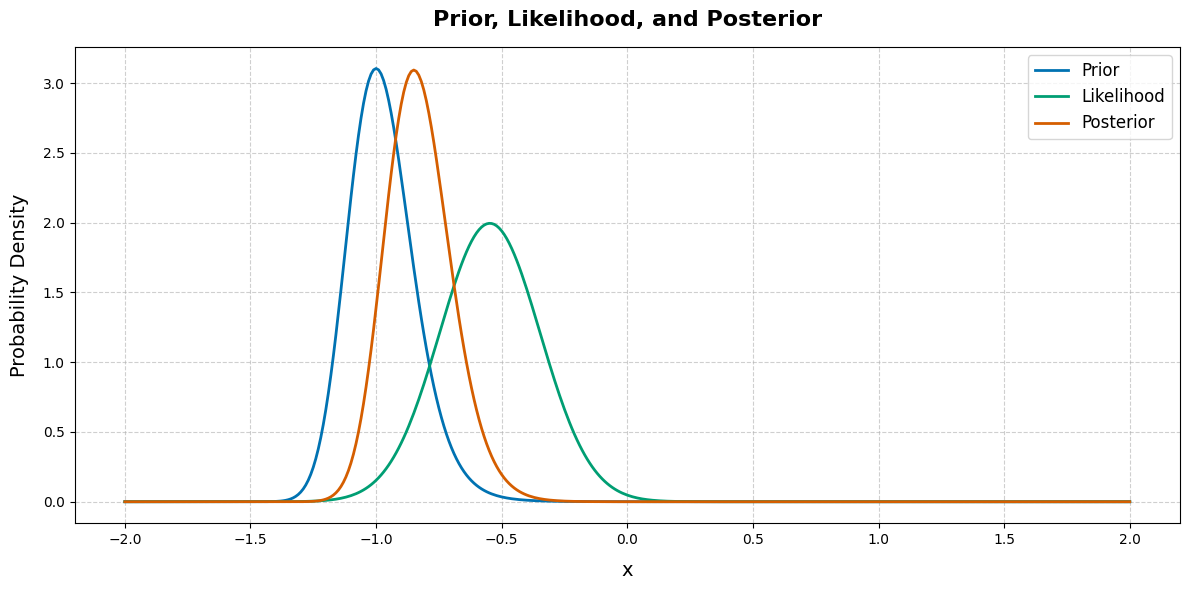

Step 3, Starting Adam optimization...
Step 3, Adam Epoch    0: Current loss: 1.99e+02
Step 3, Adam Epoch 1000: Current loss: 5.16e-01
Step 3, Adam Epoch 2000: Current loss: 4.01e-01
Step 3, Adam Epoch 3000: Current loss: 1.88e-01
Step 3, Adam Epoch 4000: Current loss: 4.56e-02
Step 3, Switching to L-BFGS optimization...
Step 3, L-BFGS Epoch    0: Current loss: 5.48e-02
Step 3, L-BFGS Epoch  100: Current loss: 3.49e-04
Step 3, L-BFGS Epoch  200: Current loss: 1.64e-04
Step 3, L-BFGS Epoch  300: Current loss: 9.10e-05
Step 3, L-BFGS Epoch  400: Current loss: 7.08e-05
Step 3, L-BFGS Epoch  500: Current loss: 6.07e-05
Step 3, L-BFGS: Early stopping at iteration 533 with loss: 6.06e-05
Step 3, Loaded best model with loss: 6.06e-05


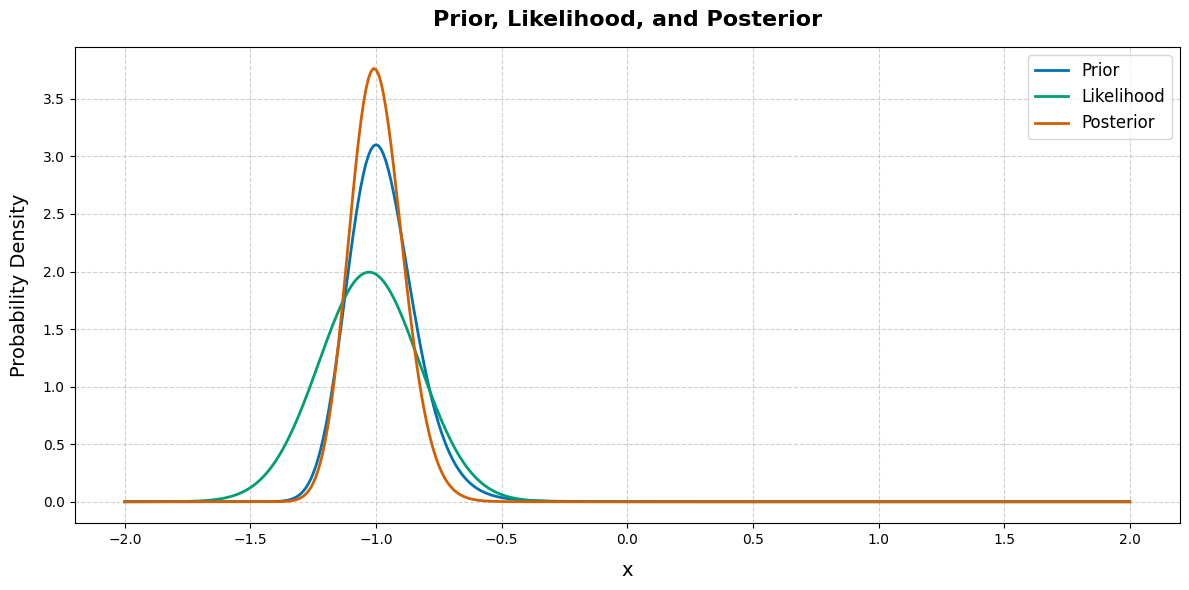

Step 4, Starting Adam optimization...
Step 4, Adam Epoch    0: Current loss: 2.00e+02
Step 4, Adam Epoch 1000: Current loss: 5.15e-01
Step 4, Adam Epoch 2000: Current loss: 5.32e-01
Step 4, Adam Epoch 3000: Current loss: 1.14e-01
Step 4, Adam Epoch 4000: Current loss: 1.48e-01
Step 4, Switching to L-BFGS optimization...
Step 4, L-BFGS Epoch    0: Current loss: 6.21e-02
Step 4, L-BFGS Epoch  100: Current loss: 7.75e-04
Step 4, L-BFGS Epoch  200: Current loss: 2.49e-04
Step 4, L-BFGS Epoch  300: Current loss: 1.43e-04
Step 4, L-BFGS: Early stopping at iteration 378 with loss: 1.29e-04
Step 4, Loaded best model with loss: 1.29e-04


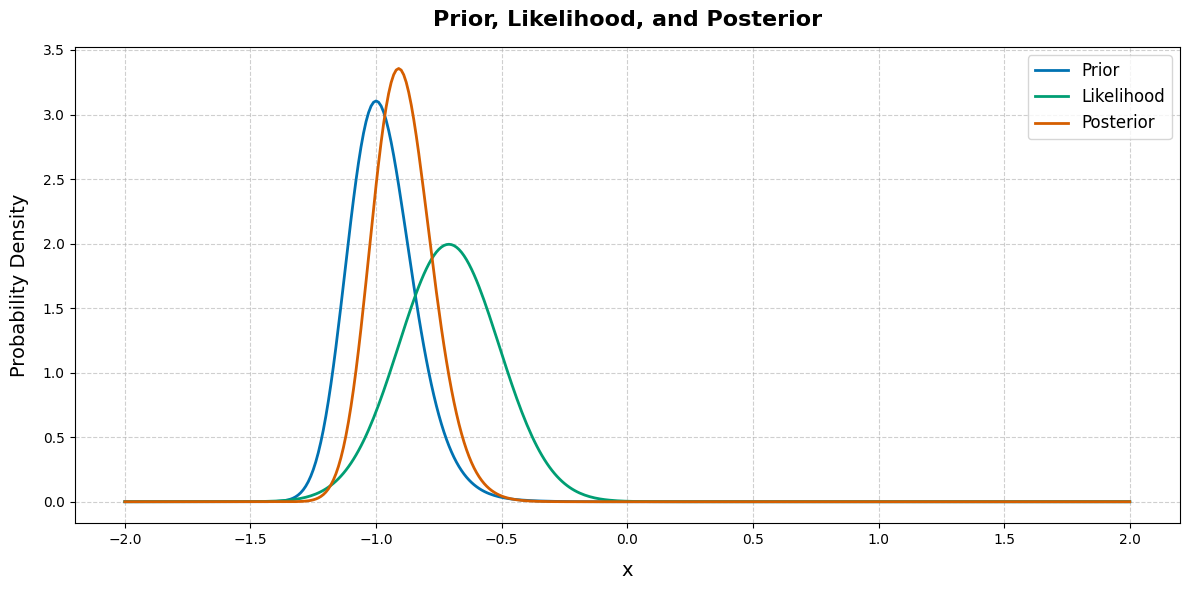

Step 5, Starting Adam optimization...
Step 5, Adam Epoch    0: Current loss: 1.99e+02
Step 5, Adam Epoch 1000: Current loss: 4.58e-01
Step 5, Adam Epoch 2000: Current loss: 3.30e-01
Step 5, Adam Epoch 3000: Current loss: 5.74e-01
Step 5, Adam Epoch 4000: Current loss: 5.98e-02
Step 5, Switching to L-BFGS optimization...
Step 5, L-BFGS Epoch    0: Current loss: 5.28e-02
Step 5, L-BFGS Epoch  100: Current loss: 5.27e-04
Step 5, L-BFGS Epoch  200: Current loss: 2.28e-04
Step 5, L-BFGS Epoch  300: Current loss: 1.70e-04
Step 5, L-BFGS Epoch  400: Current loss: 1.28e-04
Step 5, L-BFGS: Early stopping at iteration 489 with loss: 1.19e-04
Step 5, Loaded best model with loss: 1.19e-04


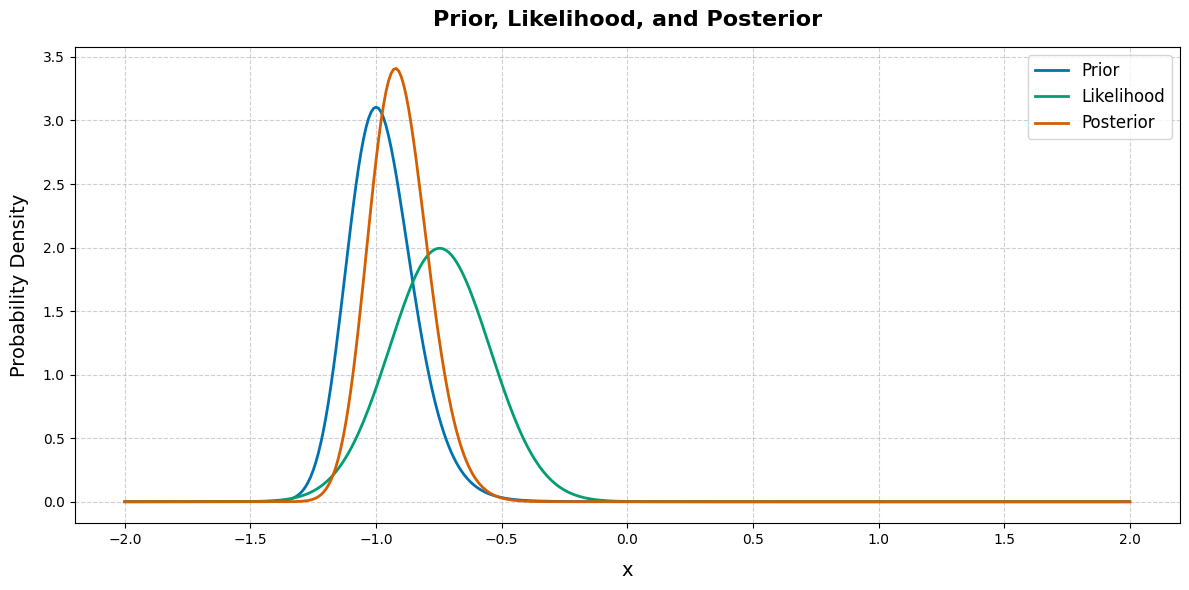

Step 6, Starting Adam optimization...
Step 6, Adam Epoch    0: Current loss: 1.99e+02
Step 6, Adam Epoch 1000: Current loss: 4.42e-01
Step 6, Adam Epoch 2000: Current loss: 3.13e-01
Step 6, Adam Epoch 3000: Current loss: 1.78e-01
Step 6, Adam Epoch 4000: Current loss: 1.09e-01
Step 6, Switching to L-BFGS optimization...
Step 6, L-BFGS Epoch    0: Current loss: 5.24e-02
Step 6, L-BFGS Epoch  100: Current loss: 2.76e-04
Step 6, L-BFGS Epoch  200: Current loss: 1.21e-04
Step 6, L-BFGS Epoch  300: Current loss: 5.95e-05
Step 6, L-BFGS Epoch  400: Current loss: 4.55e-05
Step 6, L-BFGS Epoch  500: Current loss: 3.05e-05
Step 6, L-BFGS: Early stopping at iteration 583 with loss: 2.69e-05
Step 6, Loaded best model with loss: 2.69e-05


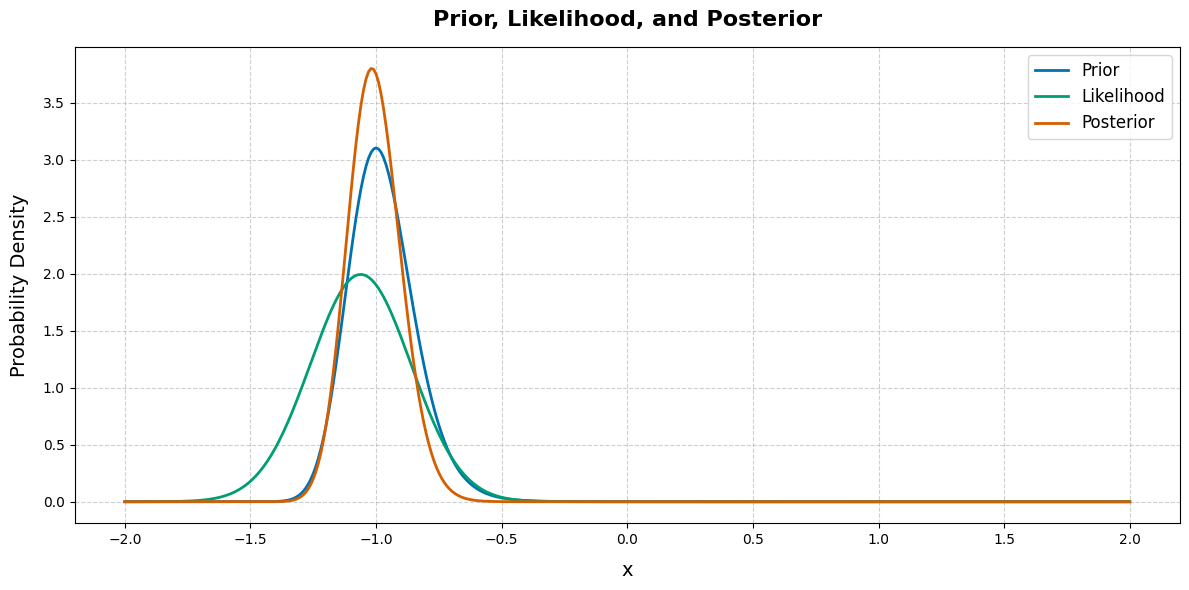

Step 7, Starting Adam optimization...
Step 7, Adam Epoch    0: Current loss: 2.00e+02
Step 7, Adam Epoch 1000: Current loss: 5.50e-01
Step 7, Adam Epoch 2000: Current loss: 5.05e-01
Step 7, Adam Epoch 3000: Current loss: 9.13e-02
Step 7, Adam Epoch 4000: Current loss: 6.84e-02
Step 7, Switching to L-BFGS optimization...
Step 7, L-BFGS Epoch    0: Current loss: 6.15e-02
Step 7, L-BFGS Epoch  100: Current loss: 9.08e-04
Step 7, L-BFGS Epoch  200: Current loss: 9.31e-05
Step 7, L-BFGS Epoch  300: Current loss: 2.77e-05
Step 7, L-BFGS Epoch  400: Current loss: 2.21e-05
Step 7, L-BFGS Epoch  500: Current loss: 1.70e-05
Step 7, L-BFGS Epoch  600: Current loss: 1.46e-05
Step 7, L-BFGS: Early stopping at iteration 612 with loss: 1.46e-05
Step 7, Loaded best model with loss: 1.46e-05


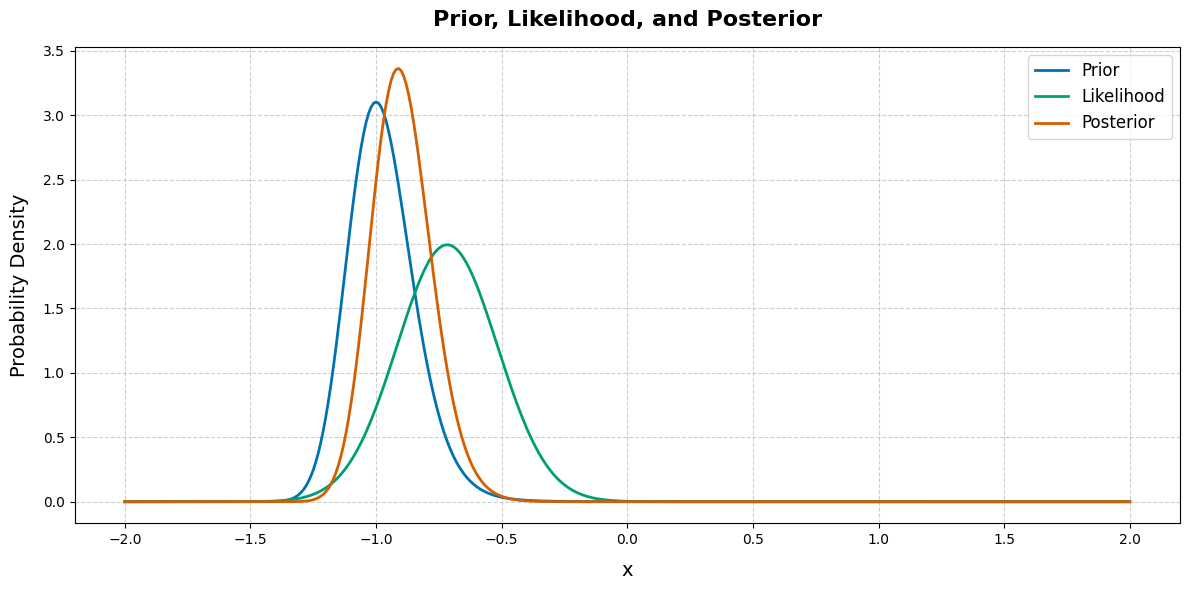

Step 8, Starting Adam optimization...
Step 8, Adam Epoch    0: Current loss: 1.99e+02
Step 8, Adam Epoch 1000: Current loss: 4.55e-01
Step 8, Adam Epoch 2000: Current loss: 3.30e-01
Step 8, Adam Epoch 3000: Current loss: 1.32e-01
Step 8, Adam Epoch 4000: Current loss: 9.12e-02
Step 8, Switching to L-BFGS optimization...
Step 8, L-BFGS Epoch    0: Current loss: 8.63e-02
Step 8, L-BFGS Epoch  100: Current loss: 4.63e-04
Step 8, L-BFGS Epoch  200: Current loss: 2.01e-04
Step 8, L-BFGS Epoch  300: Current loss: 1.31e-04
Step 8, L-BFGS Epoch  400: Current loss: 8.57e-05
Step 8, L-BFGS Epoch  500: Current loss: 6.12e-05
Step 8, L-BFGS Epoch  600: Current loss: 4.96e-05
Step 8, L-BFGS Epoch  700: Current loss: 4.11e-05
Step 8, L-BFGS Epoch  800: Current loss: 3.54e-05
Step 8, L-BFGS: Early stopping at iteration 894 with loss: 3.17e-05
Step 8, Loaded best model with loss: 3.17e-05


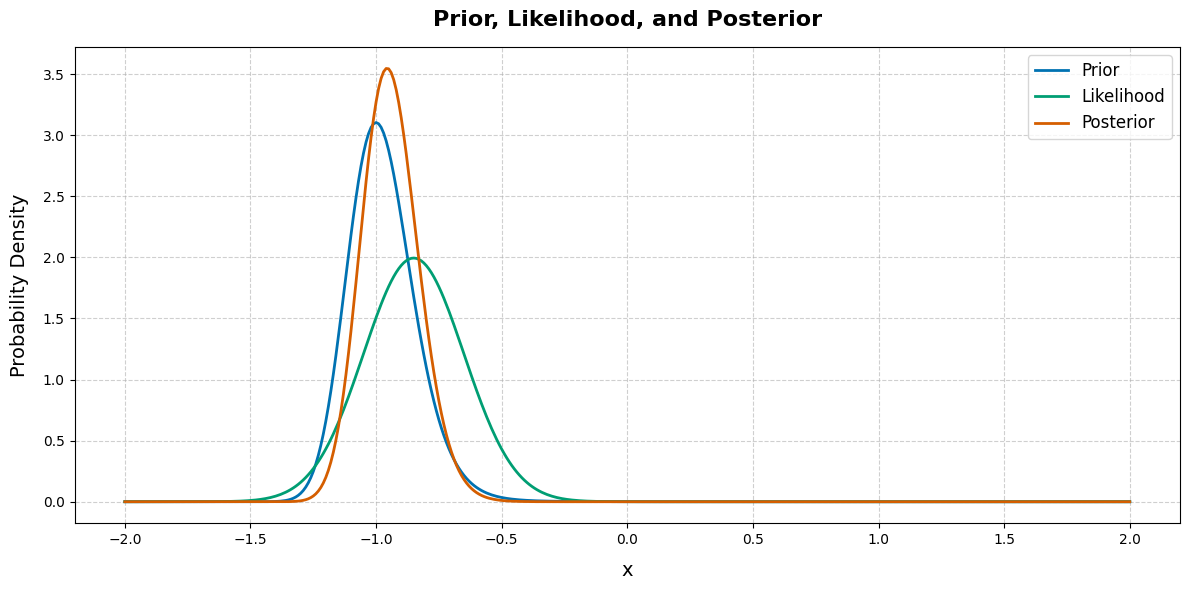

Step 9, Starting Adam optimization...
Step 9, Adam Epoch    0: Current loss: 2.00e+02
Step 9, Adam Epoch 1000: Current loss: 3.98e-01
Step 9, Adam Epoch 2000: Current loss: 2.19e-01
Step 9, Adam Epoch 3000: Current loss: 1.07e-01
Step 9, Adam Epoch 4000: Current loss: 6.21e-02
Step 9, Switching to L-BFGS optimization...
Step 9, L-BFGS Epoch    0: Current loss: 5.63e-02
Step 9, L-BFGS Epoch  100: Current loss: 5.21e-04
Step 9, L-BFGS Epoch  200: Current loss: 2.23e-04
Step 9, L-BFGS Epoch  300: Current loss: 1.49e-04
Step 9, L-BFGS Epoch  400: Current loss: 1.00e-04
Step 9, L-BFGS Epoch  500: Current loss: 8.02e-05
Step 9, L-BFGS Epoch  600: Current loss: 6.08e-05
Step 9, L-BFGS: Early stopping at iteration 691 with loss: 5.76e-05
Step 9, Loaded best model with loss: 5.76e-05


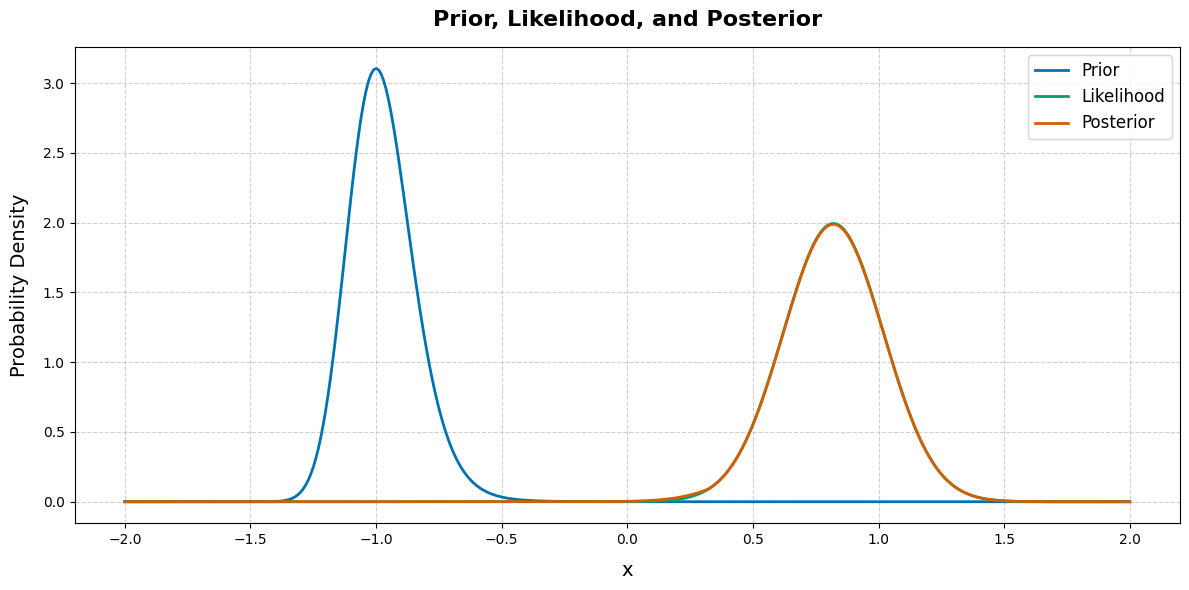

Step 10, Starting Adam optimization...
Step 10, Adam Epoch    0: Current loss: 1.96e+02
Step 10, Adam Epoch 1000: Current loss: 5.31e-01
Step 10, Adam Epoch 2000: Current loss: 2.42e-01
Step 10, Adam Epoch 3000: Current loss: 1.51e-01
Step 10, Adam Epoch 4000: Current loss: 7.97e-02
Step 10, Switching to L-BFGS optimization...
Step 10, L-BFGS Epoch    0: Current loss: 5.81e-02
Step 10, L-BFGS Epoch  100: Current loss: 8.88e-04
Step 10, L-BFGS Epoch  200: Current loss: 3.97e-04
Step 10, L-BFGS Epoch  300: Current loss: 2.09e-04
Step 10, L-BFGS Epoch  400: Current loss: 1.41e-04
Step 10, L-BFGS Epoch  500: Current loss: 1.05e-04
Step 10, L-BFGS Epoch  600: Current loss: 8.70e-05
Step 10, L-BFGS Epoch  700: Current loss: 6.85e-05
Step 10, L-BFGS Epoch  800: Current loss: 5.81e-05
Step 10, L-BFGS Epoch  900: Current loss: 4.90e-05
Step 10, Loaded best model with loss: 4.37e-05


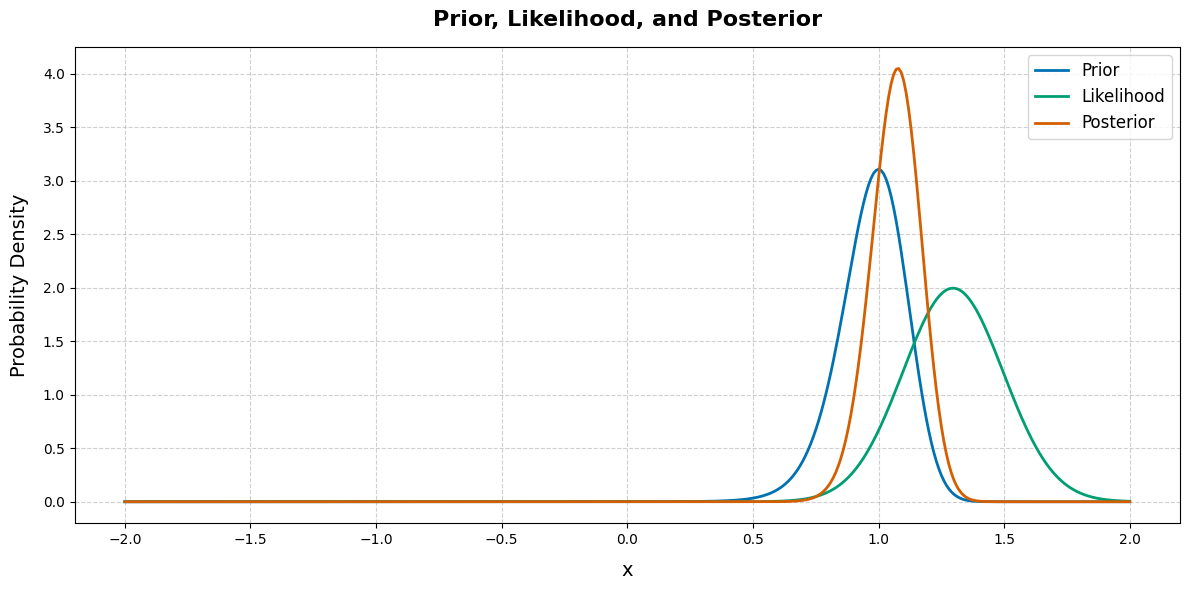

Step 11, Starting Adam optimization...
Step 11, Adam Epoch    0: Current loss: 2.00e+02
Step 11, Adam Epoch 1000: Current loss: 7.33e-01
Step 11, Adam Epoch 2000: Current loss: 2.38e-01
Step 11, Adam Epoch 3000: Current loss: 6.99e-02
Step 11, Adam Epoch 4000: Current loss: 3.30e-02
Step 11, Switching to L-BFGS optimization...
Step 11, L-BFGS Epoch    0: Current loss: 4.34e-02
Step 11, L-BFGS Epoch  100: Current loss: 6.72e-04
Step 11, L-BFGS Epoch  200: Current loss: 1.30e-04
Step 11, L-BFGS Epoch  300: Current loss: 4.60e-05
Step 11, L-BFGS Epoch  400: Current loss: 2.45e-05
Step 11, L-BFGS Epoch  500: Current loss: 1.88e-05
Step 11, L-BFGS: Early stopping at iteration 541 with loss: 1.77e-05
Step 11, Loaded best model with loss: 1.77e-05


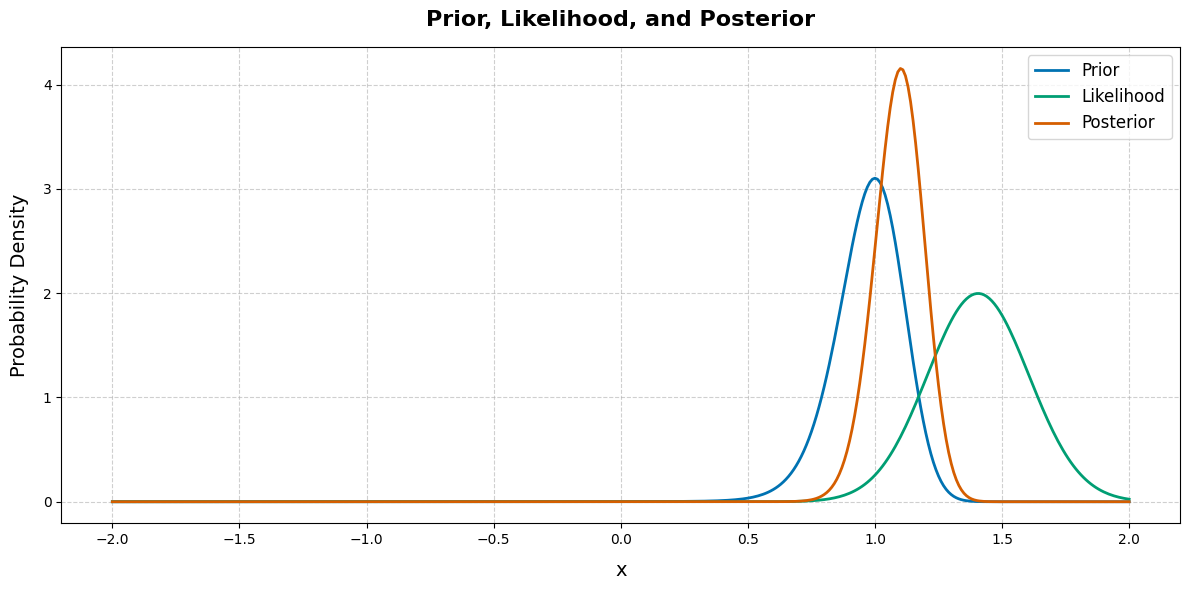

Step 12, Starting Adam optimization...
Step 12, Adam Epoch    0: Current loss: 2.00e+02
Step 12, Adam Epoch 1000: Current loss: 9.66e-01
Step 12, Adam Epoch 2000: Current loss: 1.42e+00
Step 12, Adam Epoch 3000: Current loss: 1.91e-01
Step 12, Adam Epoch 4000: Current loss: 7.91e-02
Step 12, Switching to L-BFGS optimization...
Step 12, L-BFGS Epoch    0: Current loss: 9.03e-02
Step 12, L-BFGS Epoch  100: Current loss: 1.32e-03
Step 12, L-BFGS Epoch  200: Current loss: 6.65e-04
Step 12, L-BFGS Epoch  300: Current loss: 3.48e-04
Step 12, L-BFGS Epoch  400: Current loss: 2.47e-04
Step 12, L-BFGS Epoch  500: Current loss: 1.94e-04
Step 12, L-BFGS Epoch  600: Current loss: 1.68e-04
Step 12, L-BFGS Epoch  700: Current loss: 1.32e-04
Step 12, L-BFGS Epoch  800: Current loss: 1.08e-04
Step 12, L-BFGS: Early stopping at iteration 840 with loss: 1.08e-04
Step 12, Loaded best model with loss: 1.08e-04


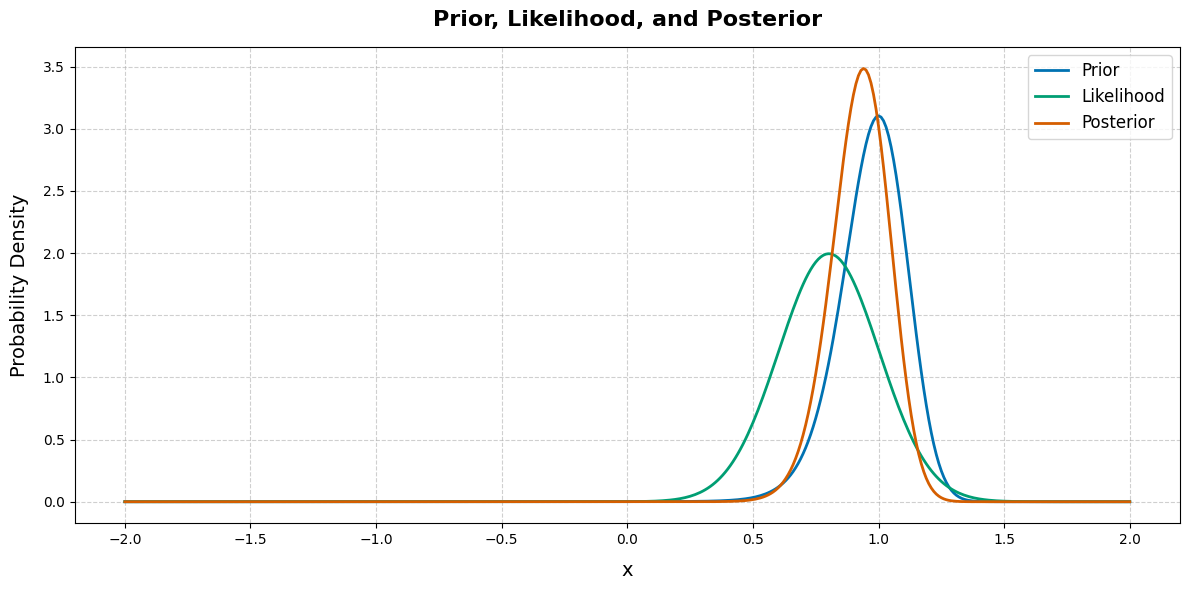

Step 13, Starting Adam optimization...
Step 13, Adam Epoch    0: Current loss: 1.99e+02
Step 13, Adam Epoch 1000: Current loss: 5.55e-01
Step 13, Adam Epoch 2000: Current loss: 1.88e-01
Step 13, Adam Epoch 3000: Current loss: 1.29e-01
Step 13, Adam Epoch 4000: Current loss: 6.19e-02
Step 13, Switching to L-BFGS optimization...
Step 13, L-BFGS Epoch    0: Current loss: 4.29e-02
Step 13, L-BFGS Epoch  100: Current loss: 2.10e-04
Step 13, L-BFGS Epoch  200: Current loss: 1.00e-04
Step 13, L-BFGS Epoch  300: Current loss: 7.32e-05
Step 13, L-BFGS Epoch  400: Current loss: 5.75e-05
Step 13, L-BFGS Epoch  500: Current loss: 4.72e-05
Step 13, L-BFGS Epoch  600: Current loss: 3.82e-05
Step 13, L-BFGS: Early stopping at iteration 680 with loss: 3.68e-05
Step 13, Loaded best model with loss: 3.68e-05


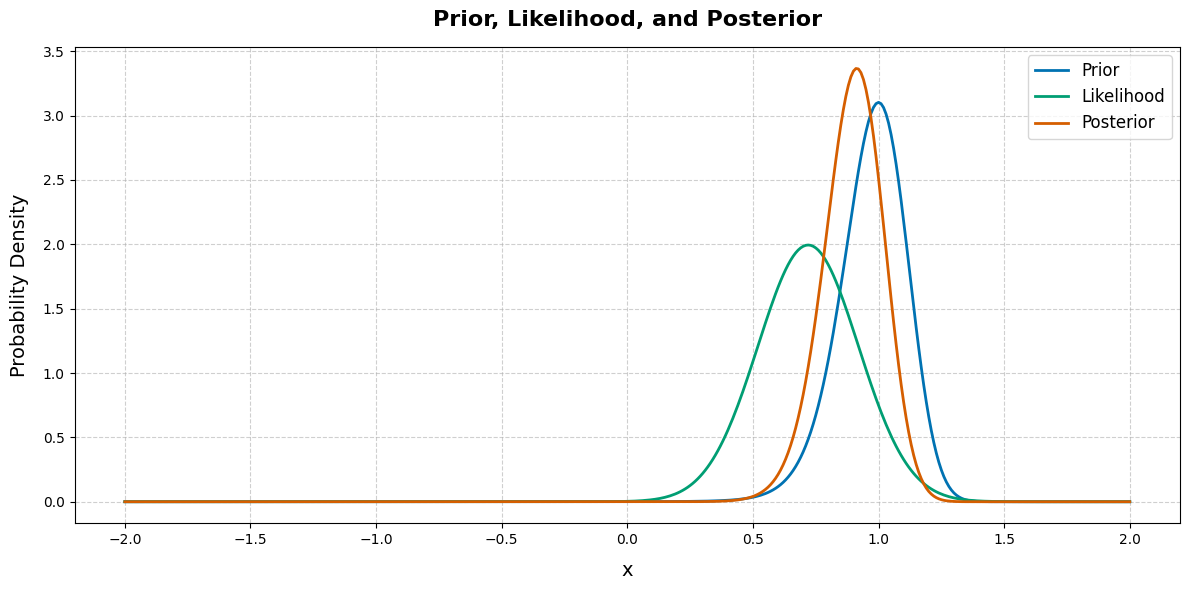

Step 14, Starting Adam optimization...
Step 14, Adam Epoch    0: Current loss: 1.99e+02
Step 14, Adam Epoch 1000: Current loss: 5.99e-01
Step 14, Adam Epoch 2000: Current loss: 2.80e-01
Step 14, Adam Epoch 3000: Current loss: 4.34e-01
Step 14, Adam Epoch 4000: Current loss: 1.32e-01
Step 14, Switching to L-BFGS optimization...
Step 14, L-BFGS Epoch    0: Current loss: 2.90e-02
Step 14, L-BFGS Epoch  100: Current loss: 2.11e-04
Step 14, L-BFGS Epoch  200: Current loss: 6.94e-05
Step 14, L-BFGS Epoch  300: Current loss: 3.50e-05
Step 14, L-BFGS Epoch  400: Current loss: 2.14e-05
Step 14, L-BFGS Epoch  500: Current loss: 1.75e-05
Step 14, L-BFGS: Early stopping at iteration 515 with loss: 1.75e-05
Step 14, Loaded best model with loss: 1.75e-05


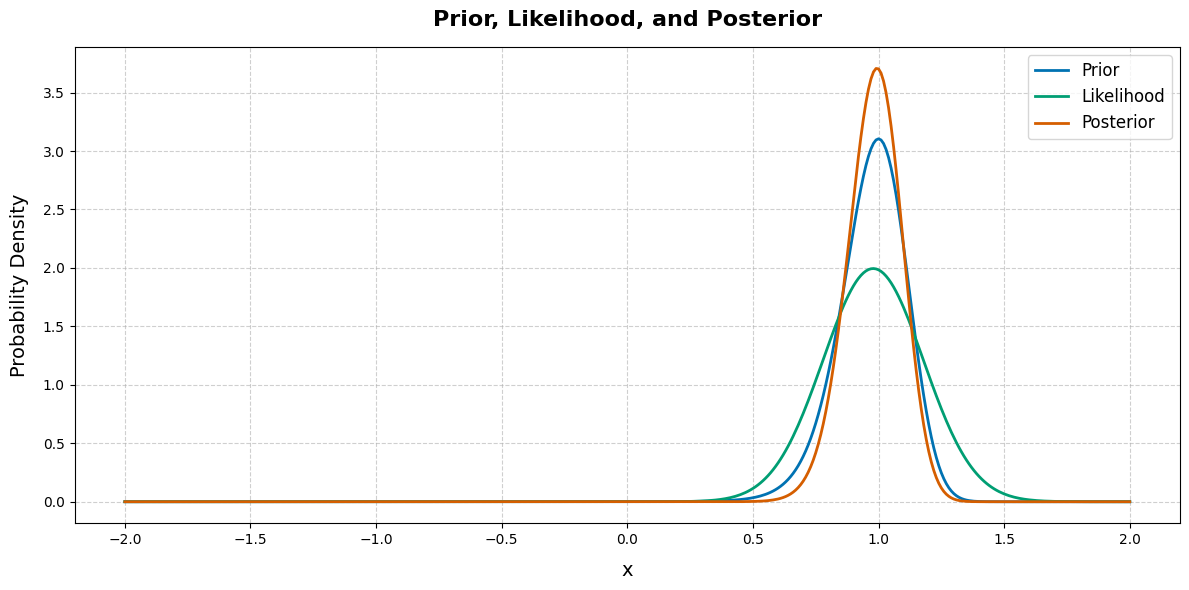

Step 15, Starting Adam optimization...
Step 15, Adam Epoch    0: Current loss: 1.99e+02
Step 15, Adam Epoch 1000: Current loss: 4.90e-01
Step 15, Adam Epoch 2000: Current loss: 1.43e-01
Step 15, Adam Epoch 3000: Current loss: 8.25e-02
Step 15, Adam Epoch 4000: Current loss: 6.33e-02
Step 15, Switching to L-BFGS optimization...
Step 15, L-BFGS Epoch    0: Current loss: 4.64e-02
Step 15, L-BFGS Epoch  100: Current loss: 3.71e-04
Step 15, L-BFGS Epoch  200: Current loss: 1.20e-04
Step 15, L-BFGS Epoch  300: Current loss: 7.64e-05
Step 15, L-BFGS Epoch  400: Current loss: 4.83e-05
Step 15, L-BFGS: Early stopping at iteration 478 with loss: 4.56e-05
Step 15, Loaded best model with loss: 4.56e-05


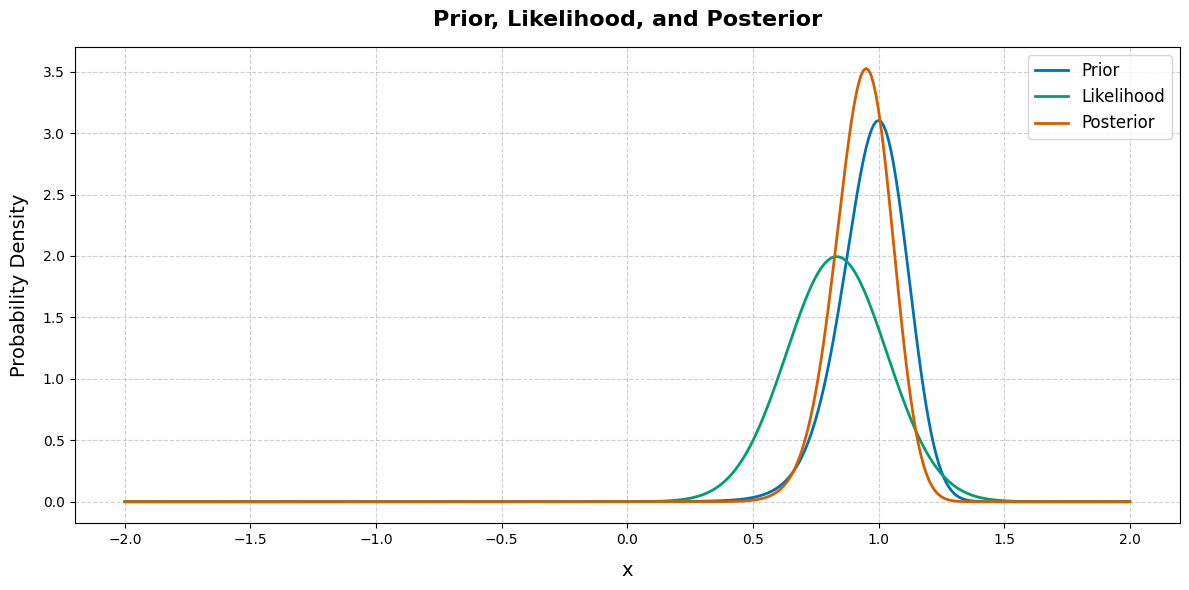

Step 16, Starting Adam optimization...
Step 16, Adam Epoch    0: Current loss: 1.99e+02
Step 16, Adam Epoch 1000: Current loss: 5.36e-01
Step 16, Adam Epoch 2000: Current loss: 2.03e-01
Step 16, Adam Epoch 3000: Current loss: 1.22e-01
Step 16, Adam Epoch 4000: Current loss: 1.00e-01
Step 16, Switching to L-BFGS optimization...
Step 16, L-BFGS Epoch    0: Current loss: 4.43e-02
Step 16, L-BFGS Epoch  100: Current loss: 1.93e-04
Step 16, L-BFGS Epoch  200: Current loss: 9.17e-05
Step 16, L-BFGS Epoch  300: Current loss: 4.41e-05
Step 16, L-BFGS Epoch  400: Current loss: 3.28e-05
Step 16, L-BFGS Epoch  500: Current loss: 2.61e-05
Step 16, L-BFGS: Early stopping at iteration 597 with loss: 2.19e-05
Step 16, Loaded best model with loss: 2.19e-05


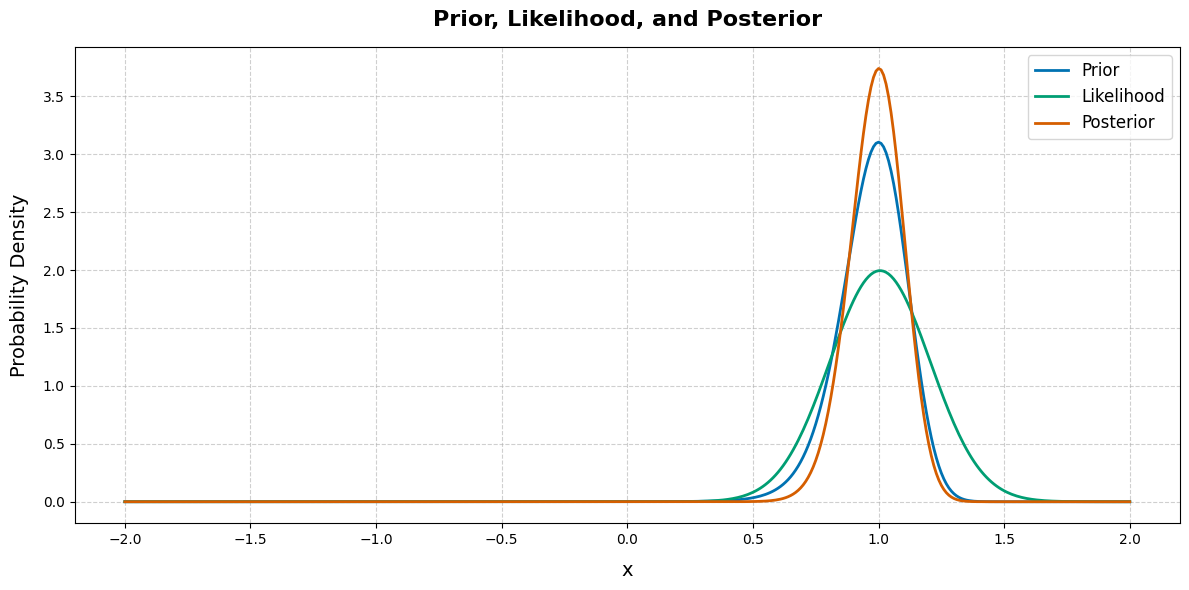

Step 17, Starting Adam optimization...
Step 17, Adam Epoch    0: Current loss: 1.99e+02
Step 17, Adam Epoch 1000: Current loss: 4.85e-01
Step 17, Adam Epoch 2000: Current loss: 8.81e-02
Step 17, Adam Epoch 3000: Current loss: 8.24e-02
Step 17, Adam Epoch 4000: Current loss: 5.63e-02
Step 17, Switching to L-BFGS optimization...
Step 17, L-BFGS Epoch    0: Current loss: 6.83e-02
Step 17, L-BFGS Epoch  100: Current loss: 1.52e-04
Step 17, L-BFGS Epoch  200: Current loss: 6.92e-05
Step 17, L-BFGS: Early stopping at iteration 243 with loss: 6.92e-05
Step 17, Loaded best model with loss: 6.92e-05


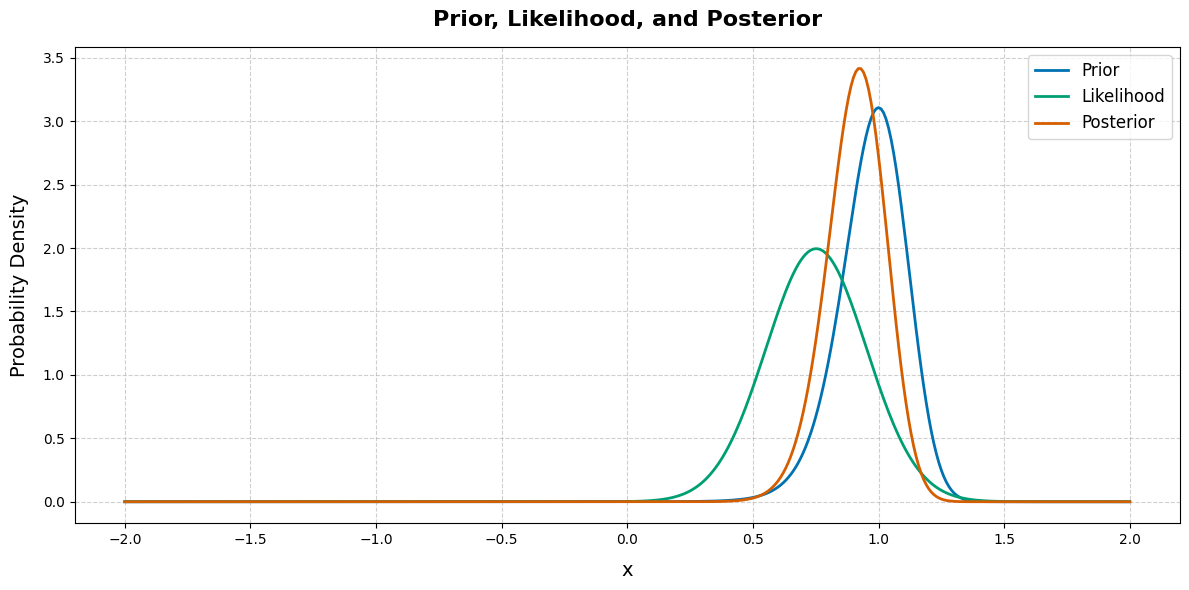

Step 18, Starting Adam optimization...
Step 18, Adam Epoch    0: Current loss: 1.99e+02
Step 18, Adam Epoch 1000: Current loss: 5.84e-01
Step 18, Adam Epoch 2000: Current loss: 2.75e-01
Step 18, Adam Epoch 3000: Current loss: 1.77e-01
Step 18, Adam Epoch 4000: Current loss: 5.49e-02
Step 18, Switching to L-BFGS optimization...
Step 18, L-BFGS Epoch    0: Current loss: 3.26e-02
Step 18, L-BFGS Epoch  100: Current loss: 2.32e-04
Step 18, L-BFGS Epoch  200: Current loss: 6.53e-05
Step 18, L-BFGS Epoch  300: Current loss: 3.18e-05
Step 18, L-BFGS Epoch  400: Current loss: 2.27e-05
Step 18, L-BFGS: Early stopping at iteration 488 with loss: 2.00e-05
Step 18, Loaded best model with loss: 2.00e-05


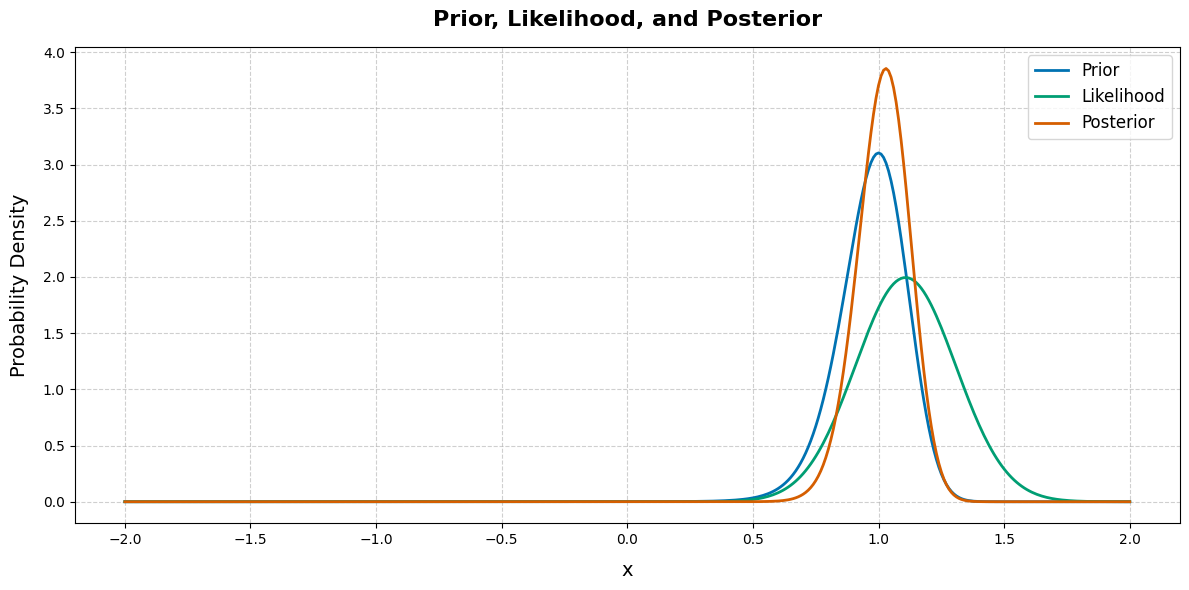

Step 19, Starting Adam optimization...
Step 19, Adam Epoch    0: Current loss: 2.00e+02
Step 19, Adam Epoch 1000: Current loss: 5.35e-01
Step 19, Adam Epoch 2000: Current loss: 1.57e-01
Step 19, Adam Epoch 3000: Current loss: 1.44e-01
Step 19, Adam Epoch 4000: Current loss: 7.66e-02
Step 19, Switching to L-BFGS optimization...
Step 19, L-BFGS Epoch    0: Current loss: 6.58e-02
Step 19, L-BFGS Epoch  100: Current loss: 2.01e-04
Step 19, L-BFGS Epoch  200: Current loss: 8.19e-05
Step 19, L-BFGS Epoch  300: Current loss: 6.12e-05
Step 19, L-BFGS Epoch  400: Current loss: 4.74e-05
Step 19, L-BFGS: Early stopping at iteration 449 with loss: 4.66e-05
Step 19, Loaded best model with loss: 4.66e-05


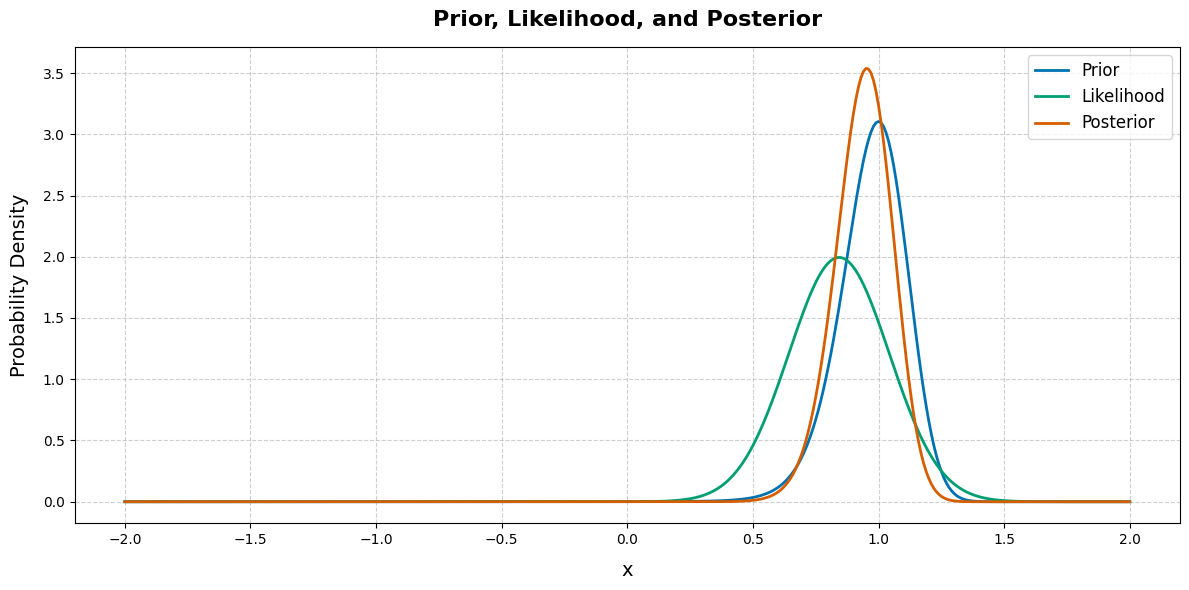

Step 20, Starting Adam optimization...
Step 20, Adam Epoch    0: Current loss: 1.99e+02
Step 20, Adam Epoch 1000: Current loss: 5.31e-01
Step 20, Adam Epoch 2000: Current loss: 1.94e-01
Step 20, Adam Epoch 3000: Current loss: 1.17e-01
Step 20, Adam Epoch 4000: Current loss: 7.68e-02
Step 20, Switching to L-BFGS optimization...
Step 20, L-BFGS Epoch    0: Current loss: 3.62e-02
Step 20, L-BFGS Epoch  100: Current loss: 2.01e-04
Step 20, L-BFGS Epoch  200: Current loss: 9.76e-05
Step 20, L-BFGS Epoch  300: Current loss: 6.28e-05
Step 20, L-BFGS Epoch  400: Current loss: 4.65e-05
Step 20, L-BFGS: Early stopping at iteration 472 with loss: 4.33e-05
Step 20, Loaded best model with loss: 4.33e-05


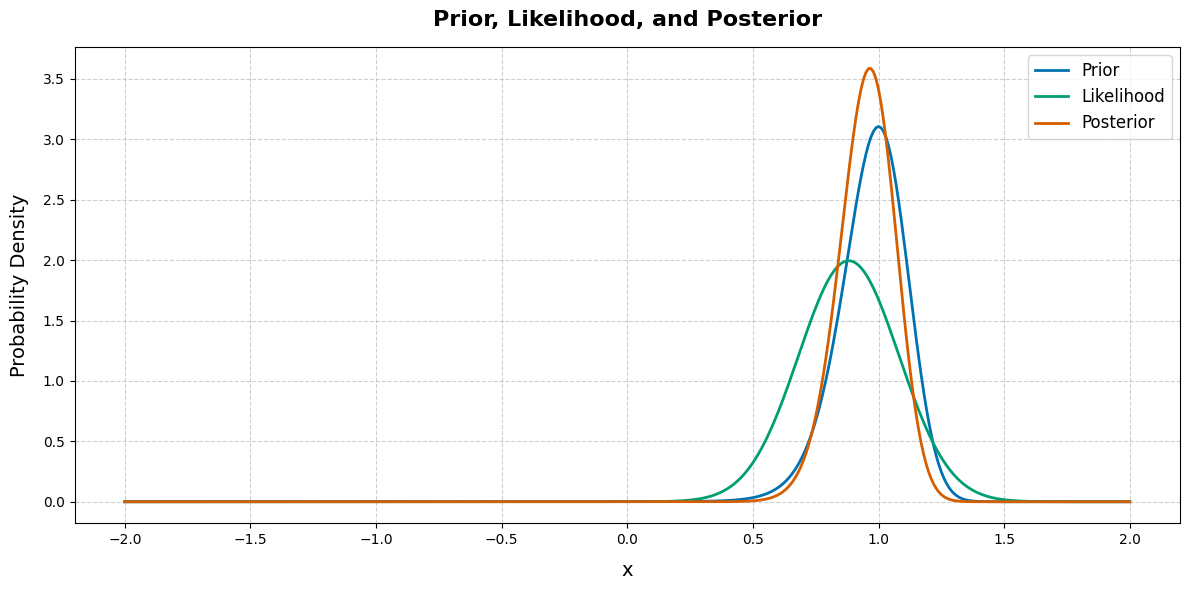

Step 21, Starting Adam optimization...
Step 21, Adam Epoch    0: Current loss: 1.99e+02
Step 21, Adam Epoch 1000: Current loss: 5.36e-01
Step 21, Adam Epoch 2000: Current loss: 1.39e-01
Step 21, Adam Epoch 3000: Current loss: 6.29e-02
Step 21, Adam Epoch 4000: Current loss: 4.60e-02
Step 21, Switching to L-BFGS optimization...
Step 21, L-BFGS Epoch    0: Current loss: 6.11e-02
Step 21, L-BFGS Epoch  100: Current loss: 3.35e-04
Step 21, L-BFGS Epoch  200: Current loss: 1.67e-04
Step 21, L-BFGS Epoch  300: Current loss: 9.11e-05
Step 21, L-BFGS Epoch  400: Current loss: 7.26e-05
Step 21, L-BFGS Epoch  500: Current loss: 5.91e-05
Step 21, L-BFGS Epoch  600: Current loss: 4.26e-05
Step 21, L-BFGS: Early stopping at iteration 667 with loss: 4.03e-05
Step 21, Loaded best model with loss: 4.03e-05


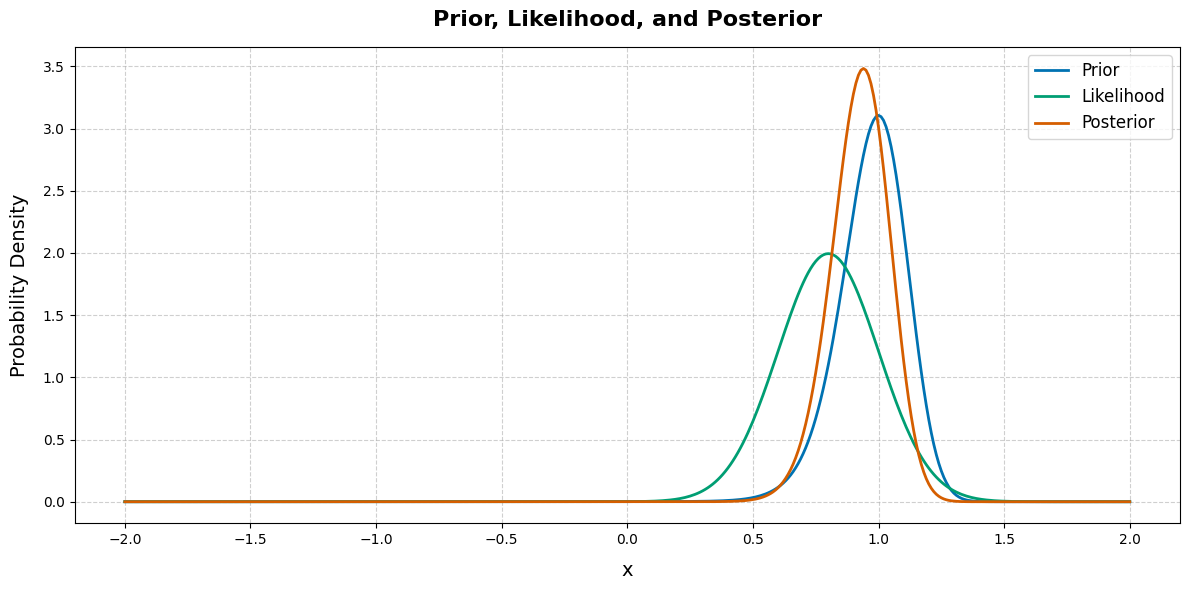

Step 22, Starting Adam optimization...
Step 22, Adam Epoch    0: Current loss: 1.99e+02
Step 22, Adam Epoch 1000: Current loss: 5.57e-01
Step 22, Adam Epoch 2000: Current loss: 2.46e-01
Step 22, Adam Epoch 3000: Current loss: 1.17e-01
Step 22, Adam Epoch 4000: Current loss: 7.78e-02
Step 22, Switching to L-BFGS optimization...
Step 22, L-BFGS Epoch    0: Current loss: 3.40e-02
Step 22, L-BFGS Epoch  100: Current loss: 1.98e-04
Step 22, L-BFGS Epoch  200: Current loss: 8.48e-05
Step 22, L-BFGS Epoch  300: Current loss: 4.43e-05
Step 22, L-BFGS Epoch  400: Current loss: 3.54e-05
Step 22, L-BFGS: Early stopping at iteration 418 with loss: 3.54e-05
Step 22, Loaded best model with loss: 3.54e-05


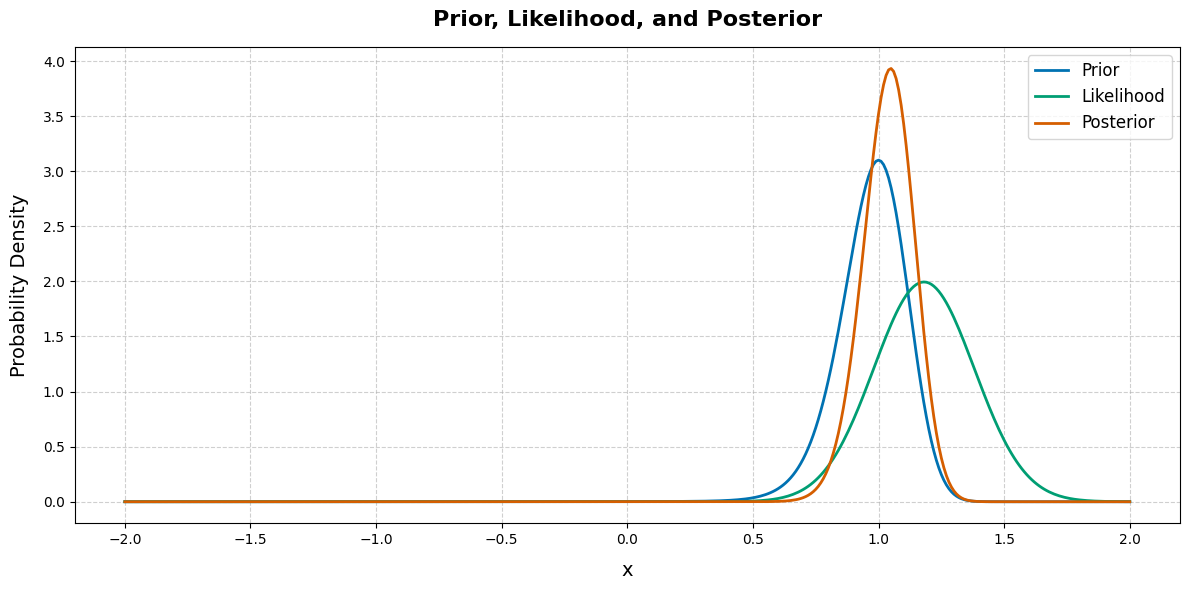

Step 23, Starting Adam optimization...
Step 23, Adam Epoch    0: Current loss: 2.00e+02
Step 23, Adam Epoch 1000: Current loss: 6.02e-01
Step 23, Adam Epoch 2000: Current loss: 2.12e-01
Step 23, Adam Epoch 3000: Current loss: 9.25e-02
Step 23, Adam Epoch 4000: Current loss: 5.22e-02
Step 23, Switching to L-BFGS optimization...
Step 23, L-BFGS Epoch    0: Current loss: 4.35e-02
Step 23, L-BFGS Epoch  100: Current loss: 5.95e-04
Step 23, L-BFGS Epoch  200: Current loss: 1.21e-04
Step 23, L-BFGS Epoch  300: Current loss: 6.17e-05
Step 23, L-BFGS Epoch  400: Current loss: 4.84e-05
Step 23, L-BFGS Epoch  500: Current loss: 4.39e-05
Step 23, L-BFGS: Early stopping at iteration 509 with loss: 4.39e-05
Step 23, Loaded best model with loss: 4.39e-05


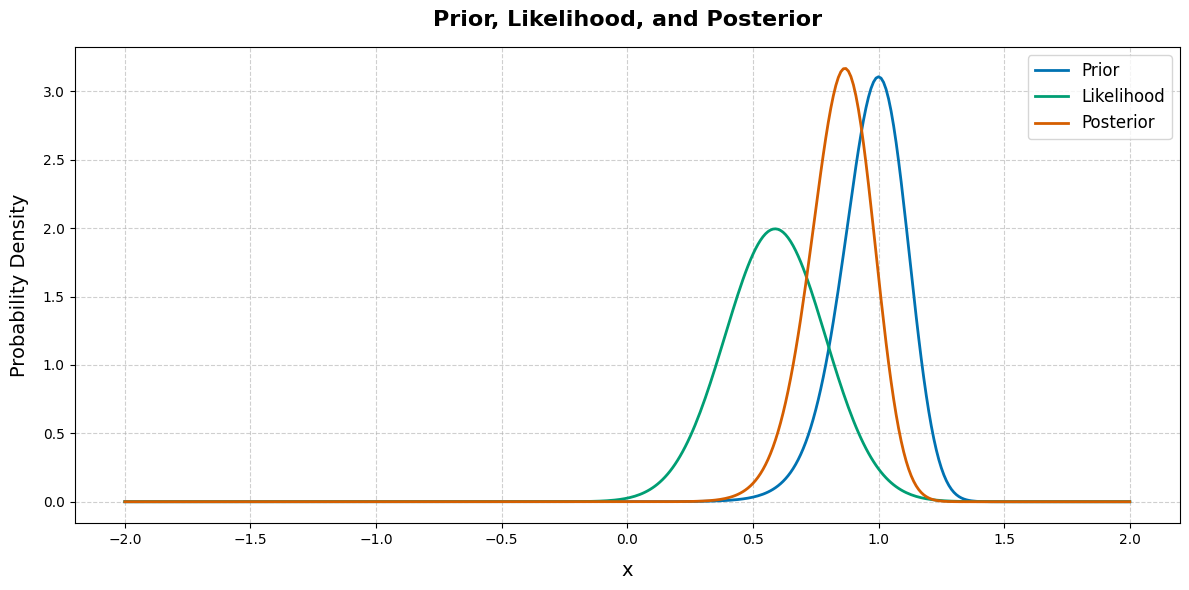

Step 24, Starting Adam optimization...
Step 24, Adam Epoch    0: Current loss: 1.98e+02
Step 24, Adam Epoch 1000: Current loss: 6.42e-01
Step 24, Adam Epoch 2000: Current loss: 4.14e-01
Step 24, Adam Epoch 3000: Current loss: 2.05e-01
Step 24, Adam Epoch 4000: Current loss: 5.63e-02
Step 24, Switching to L-BFGS optimization...
Step 24, L-BFGS Epoch    0: Current loss: 8.31e-02
Step 24, L-BFGS Epoch  100: Current loss: 1.31e-04
Step 24, L-BFGS Epoch  200: Current loss: 5.21e-05
Step 24, L-BFGS Epoch  300: Current loss: 2.57e-05
Step 24, L-BFGS: Early stopping at iteration 329 with loss: 2.55e-05
Step 24, Loaded best model with loss: 2.55e-05
Training completed in 15231.22 seconds.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

total_steps = 201
num_points = 401
domain_length = 2.0
adam_iterations, lbfgs_iterations = 5000, 1000  
learning_rate_adam, learning_rate_lbfgs = 0.01, 0.5  
obs_noise_std = 0.2

all_predictions = prediction[:, :total_steps - 1]  
x_coords_np = np.linspace(-domain_length, domain_length, num_points)
spatial_step = x_coords_np[1] - x_coords_np[0]
x_coords_torch = torch.linspace(-domain_length, domain_length, num_points, requires_grad=True, device=device)
t_coords_torch = torch.linspace(0, 2.0, total_steps, requires_grad=True, device=device)
x_grid, t_grid = torch.meshgrid(x_coords_torch, t_coords_torch, indexing="ij")
x_flat = x_grid.reshape(-1, 1)
t_flat = t_grid.reshape(-1, 1)

start_time = time.time()
seed = 100
for step in range(1, 25):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    model.apply(initialize_weights)  

    obs = observations[step]  
    posterior, mean_posterior, std_posterior = compute_posterior(obs, obs_noise_std, x_coords_np, last_column)  
    posterior_expanded = np.tile(posterior, (total_steps, 1)).T.reshape(-1, 1)

    # Define optimizers
    optimizer_adam = optim.Adam(model.parameters(), lr=learning_rate_adam)
    optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=learning_rate_lbfgs)

    losses = []
    patience = 50
    threshold = 1e-7
    stagnant_count = 0
    best_loss = float('inf')
    best_weights = None

    # Phase 1: Train with Adam
    print(f"Step {step}, Starting Adam optimization...")
    for epoch in range(adam_iterations):
        optimizer_adam.zero_grad()
        loss = compute_loss_new(x_flat, t_flat, posterior_expanded)
        loss.backward()
        optimizer_adam.step()

        current_loss = loss.item()
        losses.append(current_loss)

        if current_loss < best_loss:
            best_loss = current_loss
            best_weights = model.state_dict()

        if len(losses) > 1 and abs(losses[-1] - losses[-2]) < threshold:
            stagnant_count += 1
            if stagnant_count >= patience:
                print(f"Step {step}, Adam: Early stopping at iteration {epoch} with loss: {current_loss:.2e}")
                break
        else:
            stagnant_count = 0

        if epoch % 1000 == 0:
            print(f"Step {step}, Adam Epoch {epoch:4d}: Current loss: {current_loss:.2e}")

    # Phase 2: Switch to L-BFGS
    print(f"Step {step}, Switching to L-BFGS optimization...")
    for epoch in range(lbfgs_iterations):
        current_loss = optimizer_lbfgs.step(lambda: closure_new()).item()
        losses.append(current_loss)

        if current_loss < best_loss:
            best_loss = current_loss
            best_weights = model.state_dict()

        if len(losses) > 1 and abs(losses[-1] - losses[-2]) < threshold:
            stagnant_count += 1
            if stagnant_count >= patience:
                print(f"Step {step}, L-BFGS: Early stopping at iteration {epoch} with loss: {current_loss:.2e}")
                break
        else:
            stagnant_count = 0

        if epoch % 100 == 0:
            print(f"Step {step}, L-BFGS Epoch {epoch:4d}: Current loss: {current_loss:.2e}")

    # Load best weights
    if best_weights is not None:
        model.load_state_dict(best_weights)
        print(f"Step {step}, Loaded best model with loss: {best_loss:.2e}")

    # Plot loss
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(losses)), np.log10(losses), label="Log10(Loss)", color="#0072B2")
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Log10(Loss)", fontsize=12)
    plt.title(f"Loss at Step {step}", fontsize=14, fontweight="bold")
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.close()

    # Update predictions
    prediction = model(torch.cat((x_flat, t_flat), 1)).reshape(num_points, total_steps).cpu().detach().numpy()
    for i in range(total_steps):
        prediction[:, i] /= np.sum(prediction[:, i]) * spatial_step

    all_predictions = np.hstack((all_predictions, prediction[:, :total_steps - 1]))
    last_column = prediction[:, -1]

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

In [9]:
np.save("pinn_bayes_solutions_0_50_k_0.9_2.npy", all_predictions)